# TP Large Scale Kernel Methods

In [82]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot


## Chargement et partitionnement des données

In [83]:
###############################################################################
# Requires file ijcnn1.dat to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


# Préliminaires

## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [84]:
from sklearn.svm import SVC, LinearSVC
from time import time
from sklearn.metrics import accuracy_score

#### RBF SVM

In [85]:
# TODO

# train the model
print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
clf = SVC(kernel='rbf')
t0 = time()
clf.fit(X_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_kernel = t1-t0

# prediction
print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t0 = time()
y_pred = clf.predict(X_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_kernel += t1-t0
print("Total time : %0.3fs" % timing_kernel)

# accuracy score
accuracy_kernel = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting SVC rbf on 20000 samples...
done in 2.250s
Predicting with SVC rbf on 40000 samples...
done in 2.784s
Total time : 5.034s
classification accuracy: 0.980


#### Linear SVM

In [86]:
# TODO

# train the model
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
clf_lin = LinearSVC(dual=False)
t0 = time()
clf_lin.fit(X_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_linear = t1-t0

# prediction
print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t0 = time()
y_pred = clf_lin.predict(X_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_linear += t1-t0
print("Total time : %0.3fs" % timing_linear)

# accuracy score
accuracy_linear = accuracy_score(y_pred, y_test)
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting LinearSVC on 20000 samples...
done in 0.063s
Predicting with LinearSVC on 40000 samples...
done in 0.002s
Total time : 0.065s
classification accuracy: 0.917


Le SVM à noyau Gaussien est bien meilleur en précision que le SVM linéaire mais beaucoup plus long. Le temps de calcul pour l'apprentissage est 40 à 50 fois supérieur, et la différence est encore plus marquée sur la prédiction pour laquelle le ration est de plus de 1000.

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [87]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        # TODO use svds
        u, s, vt = svds(gram_mat, k=k)
        gram_mat_k = u @ np.diag(s) @ vt
    
    else:
        # TODO use svd
        u, s, vt = svd(gram_mat, full_matrices=False)
        gram_mat_k = u[:,:k] @ np.diag(s[:k]) @ vt[:k,:]
    
    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [88]:
from numpy.linalg import norm

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = norm(gram_mat_k - gram_signal, 'fro') / norm(gram_signal, 'fro')

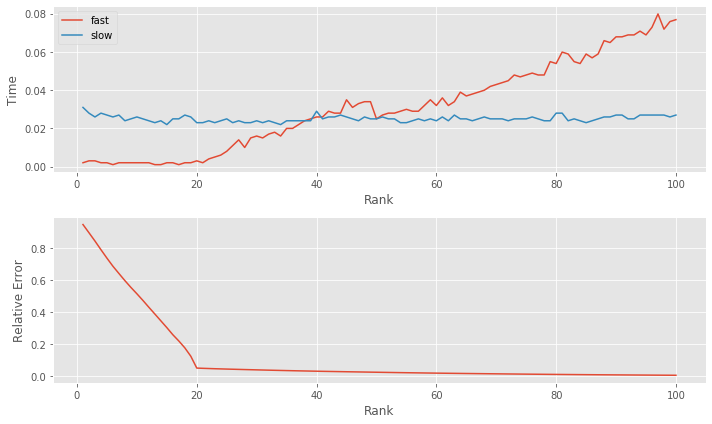

In [89]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()
ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')

ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')

plt.tight_layout()
plt.show()

La méthode "fast" est plus performante en temps de calcul pour des rangs faibles (inférieur à 40), au-delà la méthode "slow" devient plus performante.  
Le temps de calcul de la méthode "slow" est constant car on calcule d'abord la décomposition SVD complète avant de ne garder que les plus grands facteurs.  
La méthode "fast" calcule les plus grands facteurs les uns après les autres, ainsi à partir d'un certain rang le temps de calcul devient presque linéaire en fonction du rang. Cette méthode est toutefois très efficace pour des rangs faibles (inférieur à 20).

L'erreur décroit fortement et linéairement jusqu'au rang 20 pour atteindre une valeur très faible. Ce nombre 20 vient du paramètre r_signal = 20 et du paramètre intensity = 50. Le multiplicateur 50 a pour effet de rendre le signal (matrice de rang 20) prédominant sur le bruit. A delà de 20, les valeurs propres deviennent très petites. En valeur relative par rapport aux 20 premières elles deviennent donc aussi très proches, c'est pourquoi la version "fast" perd de son efficacité après. 

# Random Kernel Features (RKF)

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [90]:
from math import pi

def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components (random features)
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    # TODO
    W = np.random.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = np.random.uniform(0, 2*pi, (1,c))

    X_new_train = np.sqrt(2/c) * np.cos((X_train @ W) + b)
    X_new_test = np.sqrt(2/c) * np.cos((X_test @ W) + b)

    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [91]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_rkf = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_rkf = clf.score(Z_test, y_test)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_rkf += t1-t0
print("Total time : %0.3fs" % timing_rkf)


print("classification accuracy: %0.3f" % accuracy_rkf)

Fitting SVC linear on 20000 samples...
done in 0.945s
Predicting with SVC linear on 40000 samples...
done in 0.023s
Total time : 0.968s
classification accuracy: 0.963


La méthode Random Kernel Features (RKF) se rapproche fortement du SVM à noyau Gaussien en précision pour un temps de calcul (apprentissage et prédiction) bien inférieur (ratio supérieur à 5).

# L'approximation de Nyström

## Question 6

On implémente la méthode de Nystrom.

In [92]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel (Gaussien) approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # TODO
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]

    W_k = u @ np.diag(s) @ vt

    M = u @ np.diag(1/np.sqrt(s))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = C_train @ M
    X_new_test = C_test @ M

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [93]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_nystrom = clf.score(Z_test, y_test)
t1= time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom += t1-t0
print("Total time : %0.3fs" % timing_nystrom)

print("classification accuracy: %0.3f" % accuracy_nystrom)

Fitting SVC linear on 20000 samples...
done in 0.862s
Predicting with SVC linear on 40000 samples...
done in 0.022s
Total time : 0.884s
classification accuracy: 0.976


La méthode d'approximation de Nilstrom atteint une précision encore un peu meilleure que le Random Kernel Features (RKF) pour un temps de calcul légèrement inférieur.  
En comparaison avec le SVM à noyau Gaussien, on retrouve le même commentaire que pour le Random Kernel Features : précision très proche pour un temps de calcul (apprentissage et prédiction) bien inférieur (ratio supérieur à 6)

# Synthèse des résultats

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [94]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)

timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    
    ## Nystrom Gaussien
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t0

    ## RKF
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


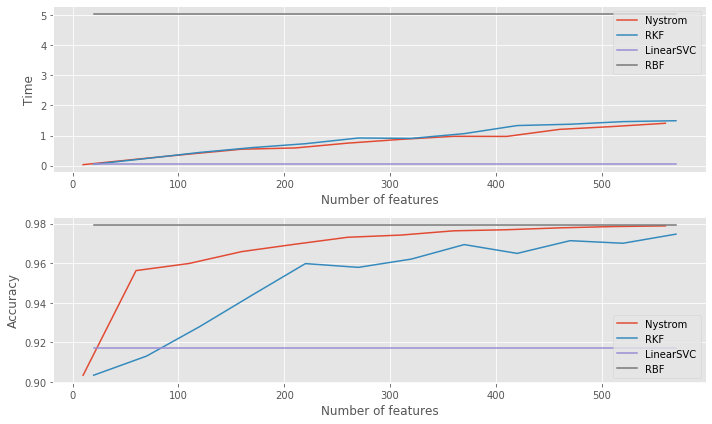

In [95]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='upper right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

Les 2 approches, Random Kernel Features et Nystrom, sont très similaires quant au temps de calcul.   
En ce qui concerne la précision, ces 2 méthodes sont plus performantes que le SVM linéaire dès qu'on dépasses 20 à 50 features.  
L'approximation Nystrom est plus performante que le Random Kernel Features quelque soit le nombre de features, la différence étant beaucoup plus marquée pour des nombres de features petits et a tendance à s'estomper en augmentant le nombre de features. Pour les 2 méthodes la précision converge vers le score du SVM à noyau Gaussien.

## Pour aller plus loin

Remplaçons le noyau Gaussien par le noyau de Laplace dans la méthode de Nyström.

In [96]:
from sklearn.metrics.pairwise import laplacian_kernel

def nystrom_laplace(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel (Laplace) approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Laplace kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = laplacian_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = linalg.svd(W, full_matrices=False)
    
    u = u[:,:k]
    s = s[:k]
    vt = vt[:k, :]
    
    W_k = u @ np.diag(s) @ vt
    
    M = u @ np.diag(1/np.sqrt(s))
    
    C_train = laplacian_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = laplacian_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = C_train @ M
    X_new_test = C_test @ M
    
    return X_new_train, X_new_test

Comme pour le noyau Gaussien, testons avec avec $c=500$ et $k=300$.

In [97]:
Z_train, Z_test = nystrom_laplace(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom_laplace = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_nystrom_laplace = clf.score(Z_test, y_test)
t1= time()
print("done in %0.3fs" % (t1 - t0))
timing_nystrom_laplace += t1-t0
print("Total time : %0.3fs" % timing_nystrom_laplace)

print("classification accuracy: %0.3f" % accuracy_nystrom_laplace)

Fitting SVC linear on 20000 samples...
done in 0.767s
Predicting with SVC linear on 40000 samples...
done in 0.023s
Total time : 0.790s
classification accuracy: 0.972


Les performances entre les 2 noyaux de l'approximation de Nystrom sont très similaires en précision et en temps de calcul.

In [98]:
timing_nystrom_laplace = np.zeros(n_ranks)
accuracy_nystrom_laplace = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    #print(i, c)
    
    ## Nystrom laplace
    Z_train, Z_test = nystrom_laplace(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom_laplace[i] = clf.score(Z_test, y_test)
    timing_nystrom_laplace[i] = time() - t0

Training SVMs for various values of c...


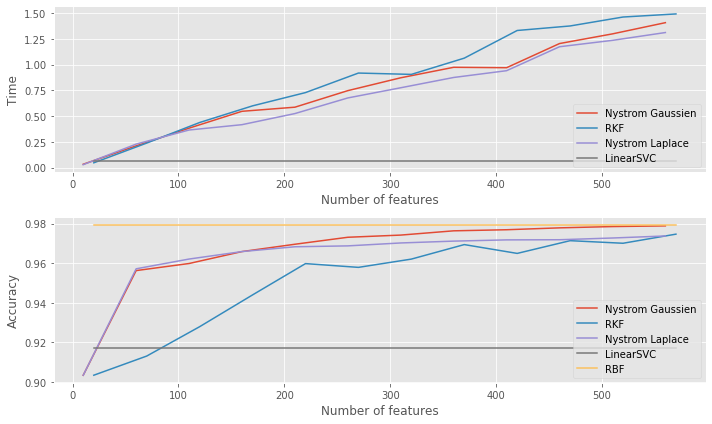

In [99]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom Gaussien')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks-10, timing_nystrom_laplace, '-', label='Nystrom Laplace')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
#ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom Gaussien')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks-10, accuracy_nystrom_laplace, '-', label='Nystrom Laplace')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

Là encore on voit que les performances des 2 noyaux de l'approximation de Nystrom sont très similaires en précision et en temps de calcul.  
Pour la précision, la convergence semble plus rapide pour le noyau Gaussien.

## Combiner les features obtenus avec les noyaux Gaussien et Laplace pour l'approximation Nystrom

In [100]:
Z_train_G, Z_test_G = nystrom(X_train, X_test, gamma, c=300, k=150, seed=44)
Z_train_L, Z_test_L = nystrom_laplace(X_train, X_test, gamma, c=300, k=150, seed=44)

Z_train = np.concatenate(( Z_train_G, Z_train_L), axis=1)
Z_test  = np.concatenate(( Z_test_G,  Z_test_L),  axis=1)    


print("Fitting SVC linear on %d samples..." % n_samples)
clf = LinearSVC(dual=False)
t0 = time()
clf.fit(Z_train, y_train)
t1 = time()
print("done in %0.3fs" % (t1 - t0))
timing_mixte = t1-t0

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy_mixte = clf.score(Z_test, y_test)
t1= time()
print("done in %0.3fs" % (t1 - t0))
timing_mixte += t1-t0
print("Total time : %0.3fs" % timing_mixte)

print("classification accuracy: %0.3f" % accuracy_mixte)

Fitting SVC linear on 20000 samples...
done in 0.851s
Predicting with SVC linear on 40000 samples...
done in 0.023s
Total time : 0.874s
classification accuracy: 0.974


Pour k=300 (150 + 150), la méthode mixte donne un résultat comparable à ceux obtenus avec les 2 noyaux.

In [101]:
timing_mixte = np.zeros(n_ranks)
accuracy_mixte = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    #print(i, c)
    
    Z_train_G, Z_test_G = nystrom(X_train, X_test, gamma, c=c, k=(c-10)//2, seed=44)
    Z_train_L, Z_test_L = nystrom_laplace(X_train, X_test, gamma, c=c, k=(c-10)//2, seed=44)
    
    Z_train = np.concatenate(( Z_train_G, Z_train_L), axis=1)
    Z_test  = np.concatenate(( Z_test_G,  Z_test_L),  axis=1)

     ## Nystrom mixte
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_mixte[i] = clf.score(Z_test, y_test)
    timing_mixte[i] = time() - t0

Training SVMs for various values of c...


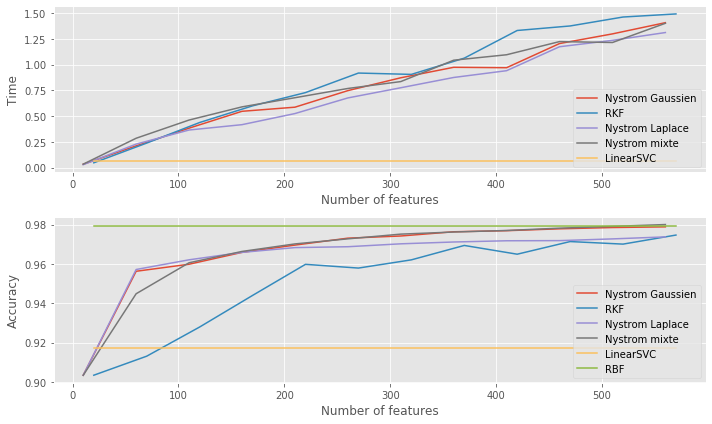

In [102]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom Gaussien')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks-10, timing_nystrom_laplace, '-', label='Nystrom Laplace')
ax1.plot(ranks-10, timing_mixte, '-', label='Nystrom mixte')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
#ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom Gaussien')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks-10, accuracy_nystrom_laplace, '-', label='Nystrom Laplace')
ax2.plot(ranks-10, accuracy_mixte, '-', label='Nystrom mixte')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

Là encore on voit que les performances de la méthode mixte sont très similaires en précision et en temps de calcul à ceux obtenus avec les 2 noyaux.    
Toutefois, nous avons, avec cette agrégation une méthode beaucoup plus "tout terrain" et qui sera donc à même de donner de bons résultats quelque soit la distribution des données d'entrées (Laplacienne ou Gaussienne).